In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from netCDF4 import Dataset
import os
import datetime as dt

This data is via:</br>
https://www.climatologylab.org/wget-terraclimate.html

The files I'll be reading in contain geospatial data for the entire US for soil moisture, dating from 1958 to 2023. The climatology Lab at UC Merced has helpfully provided this data. In order to get as much information as possible, and due to the fact that the historical data doesn't allow for highly specific subsets of data to be modeled (I was unable to model specifically Colorado) I will be examining trends in soil moisture for the entire US during this time period.

The units for soil moisture are given as `Soil Moisture, total column - at end of month (mm)` via https://www.climatologylab.org/terraclimate-variables.html

**NOTE:** This project required over six gigabytes of data. For that reason, I did not include the actual .nc files, only the wget script I used to download them. Please be sure you have properly installed if you would like to recreate this project.

NASA provides a guide for how to read in and manipulate netCDF4 data:</br>
https://www.star.nesdis.noaa.gov/atmospheric-composition-training/python_netcdf4.php

In [4]:
filepath = '../Data/model_data/'
file_name = os.listdir(filepath)
len(file_name)

1

Each file contains monthly soil moisture data for one year from 1958 to 2023, which is 65 years

In [3]:
print(f"There are {len(file_name)} files in the dataset.")

There are 65 files in the dataset.


***EXAMINING A FILE***

This article explains how to use timedeltas, which I used to parse complete dates:</br>
https://www.freecodecamp.org/news/how-to-use-timedelta-objects-in-python/

Based on the data output below, this data is monthly soil moisture data for the entire US:

    geospatial_lat_min: -89.979164
    geospatial_lat_max: 89.979164
    geospatial_lon_min: -179.97917
    geospatial_lon_max: 179.97917
    
The method explains that this data was derrived, not directly measured, which makes sense considering the scope is the whole US. This example file is from 1977:

    time_coverage_start: 1977-01-01T00:0
    time_coverage_end: 1977-12-01T00:0

In [7]:
example_file = filepath + 'TerraClimate_soil_1977.nc'
# creating netCDF4 object
example_file_id = Dataset(example_file)
# name of variable stored within file
example_file_id

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    method: These layers from TerraClimate were derived from the essential climate variables of TerraClimate. Water balance variables, actual evapotranspiration, climatic water deficit, runoff, soil moisture, and snow water equivalent were calculated using a water balance model and plant extractable soil water capacity derived from Wang-Erlandsson et al (2016).
    title: TerraClimate: monthly climate and climatic water balance for global land surfaces
    summary: This archive contains a dataset of high-spatial resolution (1/24°, ~4-km) monthly climate and climatic water balance for global terrestrial surfaces from 1958-2015. These data were created by using climatically aided interpolation, combining high-spatial resolution climatological normals from the WorldClim version 1.4 and version 2 datasets, with coarser resolution time varying (i.e. monthly) data from CRU Ts4.0 and JRA-55 to produc

I used 'soil' to access the actual data. 'crs' gives coordinate reference system information which would be helpful for a GIS project.

In [10]:
example_file_id.variables.keys()

dict_keys(['lat', 'lon', 'time', 'crs', 'soil'])

Within the 'soil' values on the second line, I can see that the dimensions correspond to time, lat and long for each item in the object. With this information, I can index through the dataset using time, and use only a subset of lat and long in order to verify that the function is working properly. Once it is, I can simply specify the entire lat and long.

In [11]:
example_file_id.variables['soil']

<class 'netCDF4._netCDF4.Variable'>
int16 soil(time, lat, lon)
    _FillValue: -32768
    units: mm
    description: Soil Moisture at End of Month
    long_name: soil_moisture_content
    standard_name: soil_moisture_content
    missing_value: -32768
    dimensions: lon lat time
    grid_mapping: crs
    coordinate_system: WGS84,EPSG:4326
    scale_factor: 0.1
    add_offset: 0.0
    _Unsigned: false
unlimited dimensions: 
current shape = (12, 4320, 8640)
filling on

In [13]:
example_file_id.variables['soil'][1,:,].data[:5]

array([[32768., 32768., 32768., ..., 32768., 32768., 32768.],
       [32768., 32768., 32768., ..., 32768., 32768., 32768.],
       [32768., 32768., 32768., ..., 32768., 32768., 32768.],
       [32768., 32768., 32768., ..., 32768., 32768., 32768.],
       [32768., 32768., 32768., ..., 32768., 32768., 32768.]])

***DATA EXTRACTION***

The data comes with a helpful variable which is the number of days since 1900-01-01 for each day at the start of each month in the dataset:

In [4]:
file = filepath + file_name[1]
# creating netCDF4 object
file_id = Dataset(file)
file_id.variables['time'][:].data

array([21549., 21580., 21608., 21639., 21669., 21700., 21730., 21761.,
       21792., 21822., 21853., 21883.])

Each one of these elements is the day since 1900-01-01 for each month in the dataset.

In [5]:
soil_df = pd.DataFrame()
for i in range(len(file_name)):
    try:
        # complete filepath
        file = filepath + file_name[i]
        # creating netCDF4 object
        file_id = Dataset(file)
        # name of variable stored within file
        file_variable = list(file_id.variables.keys())[-1]
        # list of day counts since 1900 corresponding to start of each month
        day_counts = file_id.variables['time'][:].data
        # extracting day, month, year information from the daycount since 1900-01-01 variable
        dates = [dt.datetime(1900, 1, 1) + dt.timedelta(days = day_count) for day_count in day_counts]
        # averaging the entire US's data for each month, creating list of all monthly means for entire
        # year and variable (entire file)
        var_data = [file_id.variables[file_variable][c, :, :].data.mean() for c in range(0,12)]
        # helpful pd.DataFrame technique:
        # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html
        temp_df = pd.DataFrame(index = dates, columns = ['soil_moisture'], data = var_data)
        soil_df = pd.concat([soil_df, temp_df], ignore_index=False)
    # https://stackoverflow.com/questions/9823936/how-do-i-determine-what-type-of-exception-occurred
    except Exception as ex:
        template = "An exception of type {0} occurred. Arguments:\n{1!r}"
        message = template.format(type(ex).__name__, ex.args)
        print(message)

In [6]:
# it's a datetime index df, which is good
soil_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 780 entries, 1958-01-01 to 2022-12-01
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   soil_moisture  780 non-null    float64
dtypes: float64(1)
memory usage: 12.2 KB


<Axes: >

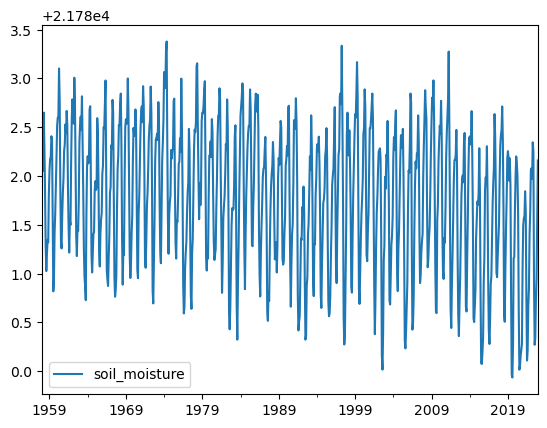

In [7]:
# verifying the data visually
soil_df.plot()

In [7]:
soil_df.isna().sum()

soil_moisture    0
dtype: int64

In [8]:
soil_df.to_csv('../Data/output_csv_files/soil_df.csv', index_label = False)